In [24]:
from typing import Dict

import os
import numpy as np
import mne
import matplotlib.pyplot as plt

# Constants
STAGE_LABELS = ["Wake", "N1", "N2", "N3", "REM"]
STAGE_MAPPING = {
    'Wake': 0,
    'N1': -2,
    'N2': -3,
    'N3': -4,
    'REM': -1
}


In [65]:
DATA_DIRECTORY = os.path.realpath("../data/raw/sample/ses2")
print(f"Files in directory {DATA_DIRECTORY}")
print(os.listdir(DATA_DIRECTORY))


# Get first polysomnogram and scoring filenames inside DATA_DIRECTORY.
filenames = os.listdir(DATA_DIRECTORY)
filename_psg = next((file for file in filenames if file.endswith(".edf")), None)
filename_scoring = next((file for file in filenames if file.endswith(".npy")), None)
if not filename_scoring or  not filename_psg:
    raise FileNotFoundError(f"Files not found in {DATA_DIRECTORY}.")

# Load automous scoring using numpy.
filepath_scoring = os.path.join(DATA_DIRECTORY, filename_scoring)
scoring = np.load(filepath_scoring)
scoring_time_hrs = np.arange(scoring.shape[0]) * 30 / 3600  # Every data point corresponds to a 30 second epoch; convert to hours.
scoring_duration = scoring_time_hrs[-1]
print(f"Found scoring file labeled {filename_scoring} with {scoring_duration:.0f} hours and {scoring_duration%1*60:.0f} minutes.")

# Load edf file containing polysomnogram information using mne
filepath_psg = os.path.join(DATA_DIRECTORY, filename_psg)
raw_obj = mne.io.read_raw_edf(filepath_psg)
ch_labels = raw_obj.ch_names
data, time_sec = raw_obj[:]


Files in directory /home/hbueno/Documents/Stanford/projects/quik_favors/SS_clinical_interface/data/raw/sample/ses2
['P001_ses2_conf.npy', 'P001_ses2_sleepscoring_manual.edf']
Found scoring file labeled P001_ses2_conf.npy with 7 hours and 26 minutes.
Extracting EDF parameters from /home/hbueno/Documents/Stanford/projects/quik_favors/SS_clinical_interface/data/raw/sample/ses2/P001_ses2_sleepscoring_manual.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


/tmp/ipykernel_251459/4017527930.py:22: RuntimeWarning: Omitted 9 annotation(s) that were outside data range.
  raw_obj = mne.io.read_raw_edf(filepath_psg)


In [80]:
naive_scoring = np.argmax(scoring, axis=1)

In [67]:
from scipy import ndimage
def analyze_uncertain_periods(confidence_data: np.ndarray, time_hrs: np.ndarray) -> Dict:
    """Analyze periods of low confidence."""
    max_confidences = np.max(confidence_data, axis=1)
    max_possible_conf = np.ceil(np.max(max_confidences))  # Round up to nearest whole number
    relative_threshold = 0.67  # equivalent to 4/6
    confidence_threshold = max_possible_conf * relative_threshold
    
    # Find regions of low confidence
    low_conf = max_confidences < confidence_threshold
    
    # Parameters for uncertain periods
    epoch_length = 30  # seconds
    min_duration = 3 * 60  # 3 minutes in seconds
    min_epochs = int(min_duration / epoch_length)
    
    # Find continuous regions
    labeled_regions, num_regions = ndimage.label(low_conf)
    
    # Analyze each region
    uncertain_periods = []
    for region in range(1, num_regions + 1):
        region_indices = np.where(labeled_regions == region)[0]
        duration = len(region_indices) * epoch_length  # duration in seconds
        
        if len(region_indices) >= min_epochs:
            uncertain_periods.append({
                'start_hour': time_hrs[region_indices[0]],
                'end_hour': time_hrs[region_indices[-1]],  # Is this the start of the endth hour?
                'duration_mins': duration / 60,
                'n_epochs': len(region_indices)
            })
    
    return {
        'n_uncertain_periods': len(uncertain_periods),
        'uncertain_periods': uncertain_periods,
        'total_uncertain_mins': sum(p['duration_mins'] for p in uncertain_periods),
        'confidence_threshold': confidence_threshold,
        'max_possible_conf': max_possible_conf
    }

uncertain_info = analyze_uncertain_periods(scoring, scoring_time_hrs)

In [85]:
uncertain_info["uncertain_periods"][0]

{'start_hour': np.float64(0.0),
 'end_hour': np.float64(0.041666666666666664),
 'duration_mins': 3.0,
 'n_epochs': 6}

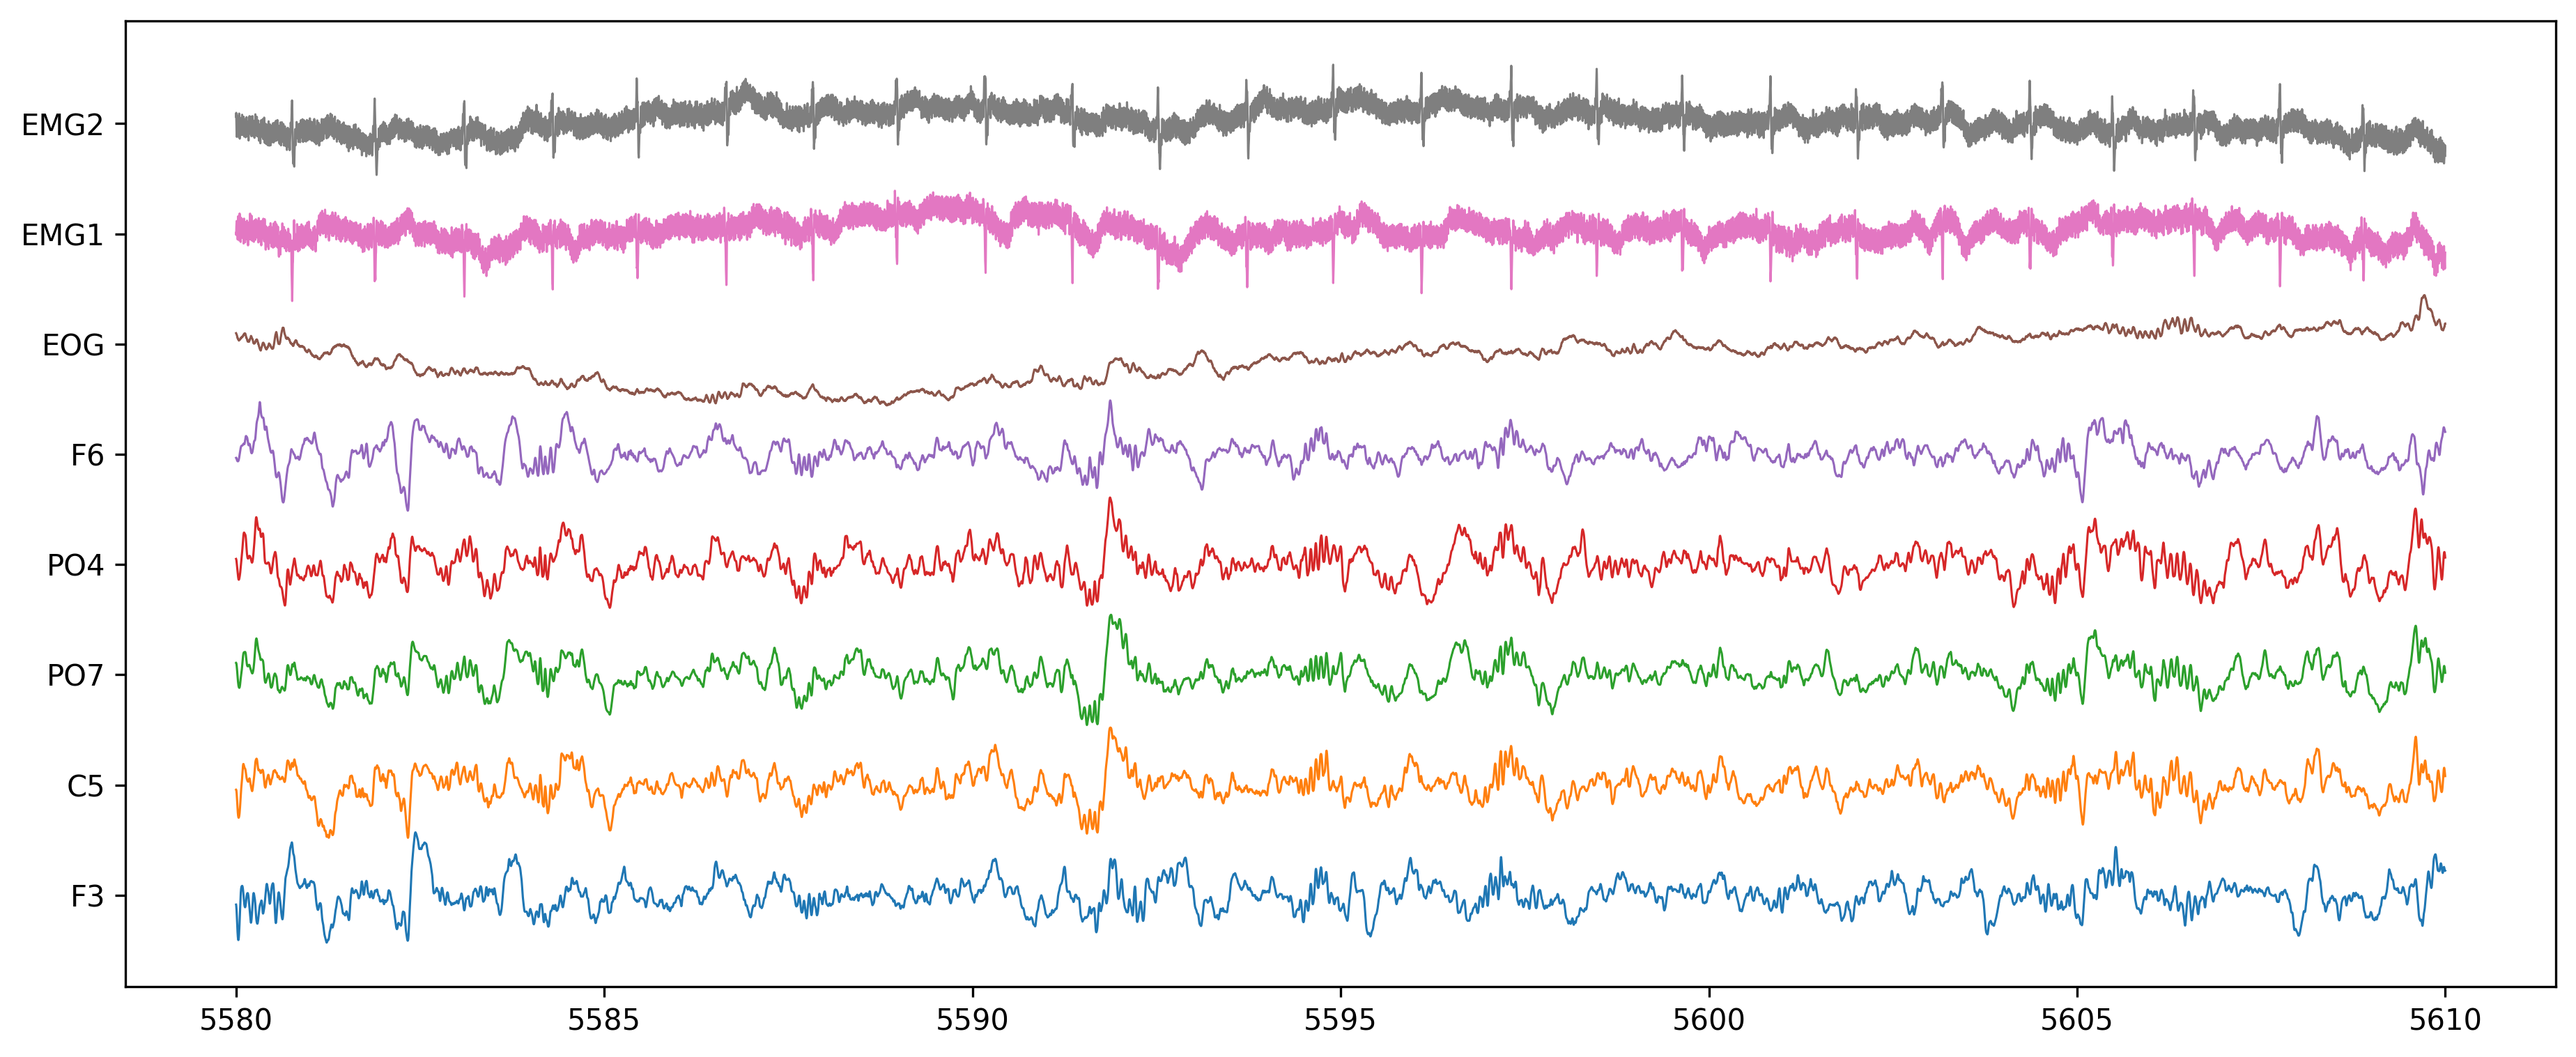

In [82]:
SELECT_AUTOSCALING = "MINMAX"
SELECT_N_UNCERTAIN_PERIOD = 5
SELECT_N_EPOCH = 3
slice_start = int(uncertain_info["uncertain_periods"][SELECT_N_UNCERTAIN_PERIOD]["start_hour"]*3600 + SELECT_N_EPOCH*30)*500
slice_stop = slice_start + 30*500
visible_time_slice = np.s_[slice_start:slice_stop]

plt.figure(figsize=(15,6), dpi=300)
for idx, signal in enumerate(data):
    # (x,y) correspond to the visibile signal for plotting.
    x = time_sec[visible_time_slice]    
    y = signal[visible_time_slice]

    # autoscaling 
    y_rms = np.sqrt(np.mean(y**2))

    if SELECT_AUTOSCALING == "MINMAX":
        c_minmax = y.max() - y.min()
        y /= c_minmax
    elif SELECT_AUTOSCALING == "RMS":
        c_rms = np.sqrt(np.mean(y**2))
        y /= c_rms
    
    plt.plot(x, y + idx, linewidth=0.75)
plt.yticks(range(data.shape[0]), ch_labels);

In [76]:
visible_time_slice

slice(5550, 5580, None)

(4.5, -0.5)

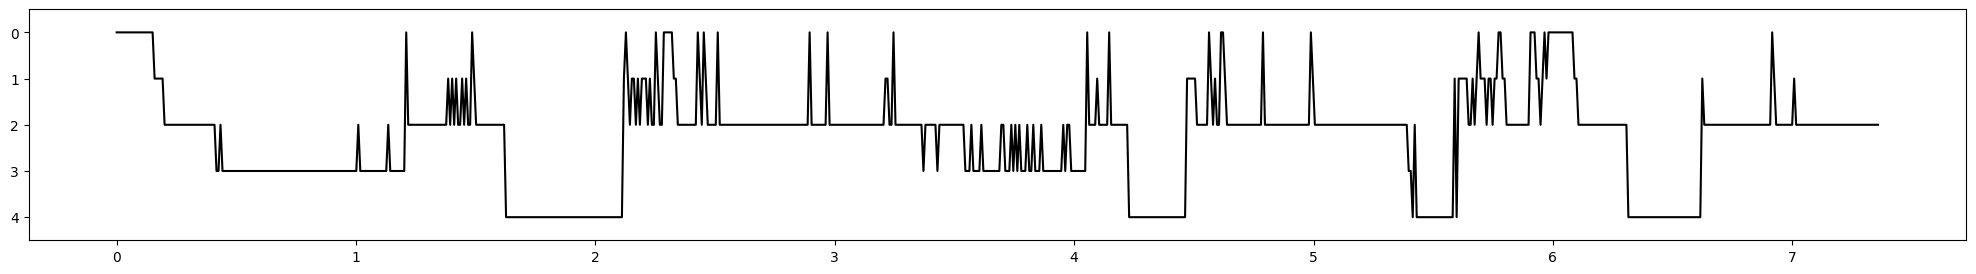

In [43]:
plt.figure(figsize=(25,3))
time_scoring = np.linspace(0, scoring.size*30, scoring.size)     # in sec
plt.plot(time_scoring/3600, scoring, "k-")
plt.ylim(4.5,-0.5)

In [44]:
scoring.shape

(893, 5)